### Libraries

In [1]:
import utils
import scipy
import random
import matplotlib
import tools as t
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx 
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy import spatial
from numpy import linalg as LA
from collections import Counter
from scipy.sparse import csgraph
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm as tqdm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_kernels
from sklearn.metrics.pairwise import rbf_kernel
from networkx.algorithms.cuts import conductance
from scipy.sparse.csgraph import connected_components
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import SpectralClustering, AffinityPropagation

sns.set_style('darkgrid')
%matplotlib inline

elbowAnalysis
silhouetteAnalyis


### Hyperparmeters

In [2]:
beta = 0.005

### Init and Load Data

In [3]:
data = np.load('/home/zz452/cluster/data/modelTishby_0_layer_data.p')
layer = data[-2] 
n_epochs, n_sample, n_dim = layer.shape
layer = np.random.randn(n_epochs, n_sample, n_dim)*(beta**2) + layer 

### Estimate cluster in each epochs

In [4]:
gamma = []
for i in tqdm(range(n_epochs)):
    M_d = spatial.distance_matrix(layer[i,:,:],
                                  layer[i,:,:],
                                  p=2)**2
    
    gamma += [1/M_d.flatten().max()]
gamma = np.mean(gamma)    

clusters = []
for i in tqdm(range(n_epochs)):
    affinity_matrix = rbf_kernel(layer[i,:,:],  
                                 gamma=1)
    k,  _, _ = t.eigenDecomposition(affinity_matrix, plot=False)
    clusters += [k[0]]
    
clusters = np.hstack(clusters)
clusters = clusters.flatten()

### Spectral Clustering in each epochs

In [5]:
cluster_labels = []
for i in tqdm(range(n_epochs)):
    nb_clusters = clusters[i]
    
    if nb_clusters == 1:
        cluster_labels += [np.zeros(n_sample).astype('int')]
    else:
        sc = SpectralClustering(n_clusters= nb_clusters,
                                assign_labels= "discretize",
                                random_state= 0,
                                affinity= 'rbf', 
                                gamma= 1).fit(layer[i,:,:])
        cluster_labels += [sc.labels_]

### Closeness Centrality

In [6]:
cc = []
for i in tqdm(range(n_epochs)):
    labels = cluster_labels[i]
    
    label_closeness = []
    for y in np.unique(labels):
        label_idx = (labels == y)
        x = layer[i,:,:][label_idx]
        upper_half = np.triu_indices(x.shape[0], k=1)
        M_d = spatial.distance_matrix(x,
                                      x,
                                      p=2)**2
         
        label_closeness += [1/M_d[upper_half].mean()]
        
    cc += [np.mean(label_closeness)]

### MI Proxy

Text(0.5, 0, 'Epoch')

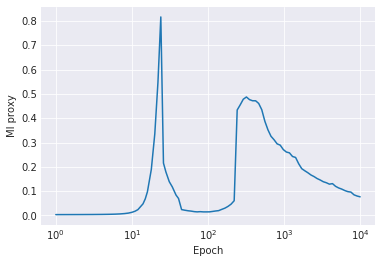

In [7]:
epoch_subsample = np.unique(np.round(np.logspace(np.log10(1), 
                                                 np.log10(9999), 
                                                 num=100,
                                                 endpoint=True)).astype(int))
plt.semilogx(epoch_subsample,1/np.array(cc))
plt.ylabel('MI proxy')
plt.xlabel('Epoch')